In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt


In [2]:
INPUT_CHANNELS = 3
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_EPOCHS = 500
L1_LAMBDA = 100

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [3]:
class Discriminator_Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Conv2d(in_channels, out_channels, 4, stride=stride, bias=False, padding_mode="reflect"))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.LeakyReLU(0.2))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()

        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"))
        self.conv_layers.append(nn.LeakyReLU(0.2))

        in_channels = features[0]
        stride = 2
        for index, feature in enumerate(features):
            if index == len(features)-1:
                stride = 1
            self.conv_layers.append(Discriminator_Block(in_channels, feature, stride=stride))
            in_channels = feature
        
        self.conv_layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
    
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        for layer in self.conv_layers:
            x = layer(x)
        
        return x

In [4]:
class Generator_Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super().__init__()
        
        self.layers = nn.ModuleList()
        if down:
            self.layers.append(nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect"))
        else:
            self.layers.append(nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False))
        
        self.layers.append(nn.BatchNorm2d(out_channels))
        if act == "relu":
            self.layers.append(nn.ReLU())
        else:
            self.layers.append(nn.LeakyReLU(0.2))
        
        self.use_dropout = use_dropout
        self.dropout_layer = nn.Dropout(0.5)

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        if self.use_dropout:
            x = self.dropout_layer(x)
        
        return x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()

        self.input_layer = nn.ModuleList()
        self.input_layer.append(nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"))
        self.input_layer.append(nn.LeakyReLU(0.2))

        self.down_layers = nn.ModuleList()
        self.down_layers.append(Generator_Block(features, features*2, down=True, act="leaky", use_dropout=False))
        self.down_layers.append(Generator_Block(features*2, features*4, down=True, act="leaky", use_dropout=False))
        self.down_layers.append(Generator_Block(features*4, features*8, down=True, act="leaky", use_dropout=False))
        self.down_layers.append(Generator_Block(features*8, features*8, down=True, act="leaky", use_dropout=False))
        self.down_layers.append(Generator_Block(features*8, features*8, down=True, act="leaky", use_dropout=False))
        self.down_layers.append(Generator_Block(features*8, features*8, down=True, act="leaky", use_dropout=False))

        self.bottleneck = nn.ModuleList()
        self.bottleneck.append(nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode="reflect"))
        self.bottleneck.append(nn.ReLU())

        self.up_layers = nn.ModuleList()
        self.up_layers.append(Generator_Block(features*8, features*8, down=False, act="relu", use_dropout=True))
        self.up_layers.append(Generator_Block(features*8*2, features*8, down=False, act="relu", use_dropout=True))
        self.up_layers.append(Generator_Block(features*8*2, features*8, down=False, act="relu", use_dropout=True))
        self.up_layers.append(Generator_Block(features*8*2, features*8, down=False, act="relu", use_dropout=True))
        self.up_layers.append(Generator_Block(features*8*2, features*4, down=False, act="relu", use_dropout=True))
        self.up_layers.append(Generator_Block(features*4*2, features*2, down=False, act="relu", use_dropout=True))
        self.up_layers.append(Generator_Block(features*2*2, features, down=False, act="relu", use_dropout=True))

        self.final_up = nn.ModuleList()
        self.final_up.append(nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1))
        self.final_up.append(nn.Tanh())

    
    def forward(self, x):
        res_values = list()
        
        for layer in self.input_layer:
            x = layer(x)
        res_values.append(x)

        for layer in self.down_layers:
            x = layer(x)
            res_values.append(x)
        
        for layer in self.bottleneck:
            x = layer(x)
        
        res_index = len(res_values)
        for layer in self.up_layers:
            
            if res_index != len(res_values):
                x = layer(torch.cat([x, res_values[res_index]], axis=1))
            else:
                x = layer(x)
            res_index-=1
        
        x = self.final_up[0](torch.cat([x, res_values[0]], axis=1))
        x = self.final_up[1](x)

        return x



In [5]:
general_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

input_transform = A.Compose(
    [
        # A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

target_transform = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

class MapDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        super().__init__()

        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)

        image = np.array(Image.open(img_path))

        input_image = image[:, :600, :]
        target_image = image[:, 600:, :]

        augmentations = general_transform(image=input_image, image0=target_image)

        input_image, target_image = augmentations["image"], augmentations["image0"]

        input_image = input_transform(image=input_image)["image"]
        target_image = target_transform(image=target_image)["image"]

        return input_image, target_image

In [6]:
def save_results(input_images, target_images, addr):
    input_images = input_images.permute(0, 2, 3, 1).detach().cpu().numpy()
    target_images = target_images.permute(0, 2, 3, 1).detach().cpu().numpy()

    for image_index in range(input_images.shape[0]):
        plt.subplot(2, 3, image_index+1)
        plt.axis("off")
        plt.imshow(input_images[image_index]*0.5 + 0.5)
    
    for image_index in range(target_images.shape[0]):
        plt.subplot(2, 3, image_index+4)
        plt.axis("off")
        plt.imshow(target_images[image_index]*0.5 + 0.5)

    plt.savefig(addr, dpi=600)

In [7]:
disc_model = Discriminator(in_channels=INPUT_CHANNELS).to(device)
gen_model = Generator(in_channels=INPUT_CHANNELS).to(device)

opt_disc = torch.optim.Adam(disc_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(gen_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

dataset = MapDataset(root_dir="E:/Hamavar/datasets/maps/maps/train")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

d_scaler = torch.cuda.amp.GradScaler()
g_scaler = torch.cuda.amp.GradScaler()

Epoch: 1, Discriminator Loss: 0.41607, Generator Loss: 33.88458
Epoch: 2, Discriminator Loss: 0.19784, Generator Loss: 18.46055
Epoch: 3, Discriminator Loss: 0.09818, Generator Loss: 17.85829
Epoch: 4, Discriminator Loss: 0.42900, Generator Loss: 15.84571
Epoch: 5, Discriminator Loss: 0.41740, Generator Loss: 16.26561
Epoch: 6, Discriminator Loss: 0.51827, Generator Loss: 15.03767
Epoch: 7, Discriminator Loss: 0.46011, Generator Loss: 14.61408
Epoch: 8, Discriminator Loss: 0.30942, Generator Loss: 15.39340
Epoch: 9, Discriminator Loss: 0.37298, Generator Loss: 14.61288
Epoch: 10, Discriminator Loss: 0.36237, Generator Loss: 14.49740
Epoch: 11, Discriminator Loss: 0.34839, Generator Loss: 14.23233
Epoch: 12, Discriminator Loss: 0.35589, Generator Loss: 13.92805
Epoch: 13, Discriminator Loss: 0.31951, Generator Loss: 13.92536
Epoch: 14, Discriminator Loss: 0.29317, Generator Loss: 13.52703
Epoch: 15, Discriminator Loss: 0.36150, Generator Loss: 13.82928
Epoch: 16, Discriminator Loss: 0.4

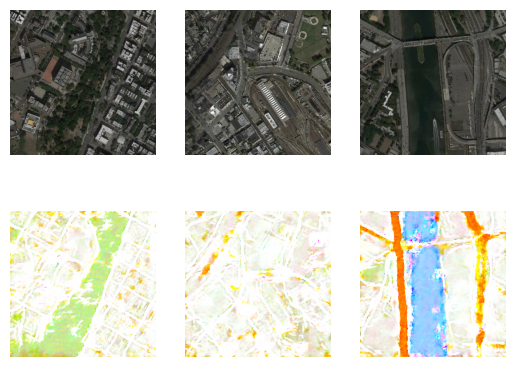

In [8]:
for epoch in range(NUM_EPOCHS):
    discriminator_epoch_loss = list()
    generator_epoch_loss = list()

    for input_img, target_img in dataloader:
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        # Training The Discriminator
        with torch.cuda.amp.autocast():
            target_fake = gen_model(input_img)
            
            real_input_scores = disc_model(input_img, target_img)
            fake_input_scores = disc_model(input_img, target_fake.detach())

            real_input_loss = bce_loss(real_input_scores, torch.ones_like(real_input_scores))
            fake_input_loss = bce_loss(fake_input_scores, torch.zeros_like(fake_input_scores))

            disc_loss = (real_input_loss + fake_input_loss)/2

        opt_disc.zero_grad()
        d_scaler.scale(disc_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Training The Generator
        with torch.cuda.amp.autocast():
            disc_fake_score = disc_model(input_img, target_fake)
            gen_fake_loss = bce_loss(disc_fake_score, torch.ones_like(disc_fake_score))
            gen_loss = gen_fake_loss + l1_loss(target_fake, target_img)*L1_LAMBDA
        
        opt_gen.zero_grad()
        g_scaler.scale(gen_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        discriminator_epoch_loss.append(disc_loss.detach().cpu())
        generator_epoch_loss.append(gen_loss.detach().cpu())

    with torch.no_grad():
        generated_targets = gen_model(input_img[0:3])
        save_results(input_img[0:3], generated_targets, f"E:/Hamavar/GenerativeAI/GAN/pix2pix/results/generated_samples/epoch_{epoch+1}.png")
    
        if epoch%50 == 0:
            torch.save(gen_model.state_dict(), f"E:/Hamavar/GenerativeAI/GAN/pix2pix/results/models/epoch_{epoch+1}.pt")

    print(f"Epoch: {epoch+1}, Discriminator Loss: {np.mean(discriminator_epoch_loss):.5f}, Generator Loss: {np.mean(generator_epoch_loss):.5f}")


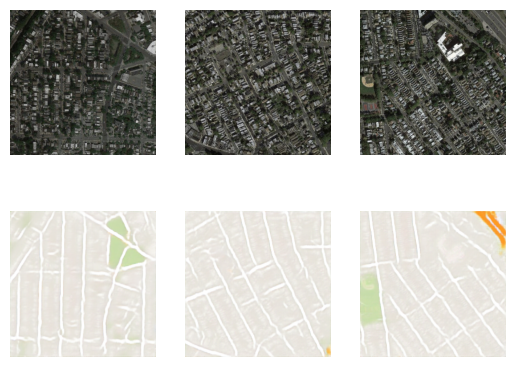

In [12]:
model = Generator(in_channels=INPUT_CHANNELS).to(device)
model.load_state_dict(torch.load("E:/Hamavar/GenerativeAI/GAN/pix2pix/results/models/epoch_200.pt"))
model.eval()

test_dataset = MapDataset(root_dir="E:/Hamavar/datasets/maps/maps/val")
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)
with torch.no_grad():
    for input_image, target_image in test_dataloader:
        generated_targets = model(input_img[3:6])
        save_results(input_img[3:6], generated_targets, f"E:/Hamavar/GenerativeAI/GAN/pix2pix/results/generated_samples/epoch_{epoch+1}.png")
        break
    